In [1]:
import urllib, json
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['font.size'] = 20

In [2]:
data = pd.read_csv("observed-solar-cycle-indices.csv")

In [3]:
dt = data.rename(columns={'time-tag': 'date'})
dt['date'] = pd.to_datetime(dt['date'], format='%Y-%m')
dt = dt.set_index('date')
# Fill potential gaps with Null
dt = dt.asfreq('MS')
dt = dt.sort_index()
dt.head()

,Unnamed: 0,ssn,smoothed_ssn,observed_swpc_ssn,smoothed_swpc_ssn,f10.7,smoothed_f10.7
date,,,,,,,
1749-01-01,0,96.7,-1.0,-1.0,-1.0,-1.0,-1.0
1749-02-01,1,104.3,-1.0,-1.0,-1.0,-1.0,-1.0
1749-03-01,2,116.7,-1.0,-1.0,-1.0,-1.0,-1.0
1749-04-01,3,92.8,-1.0,-1.0,-1.0,-1.0,-1.0
1749-05-01,4,141.7,-1.0,-1.0,-1.0,-1.0,-1.0


In [4]:
sunspot_train_data = dt[(dt.index<="1990-01")]
sunspotNumber_train_data = sunspot_train_data['ssn']
fft_result = np.fft.fft(sunspotNumber_train_data)
frequencies = np.fft.fftfreq(len(sunspotNumber_train_data))
print(sunspot_train_data.index.max())
print(sunspot_train_data.index.min())


1990-01-01 00:00:00
1749-01-01 00:00:00


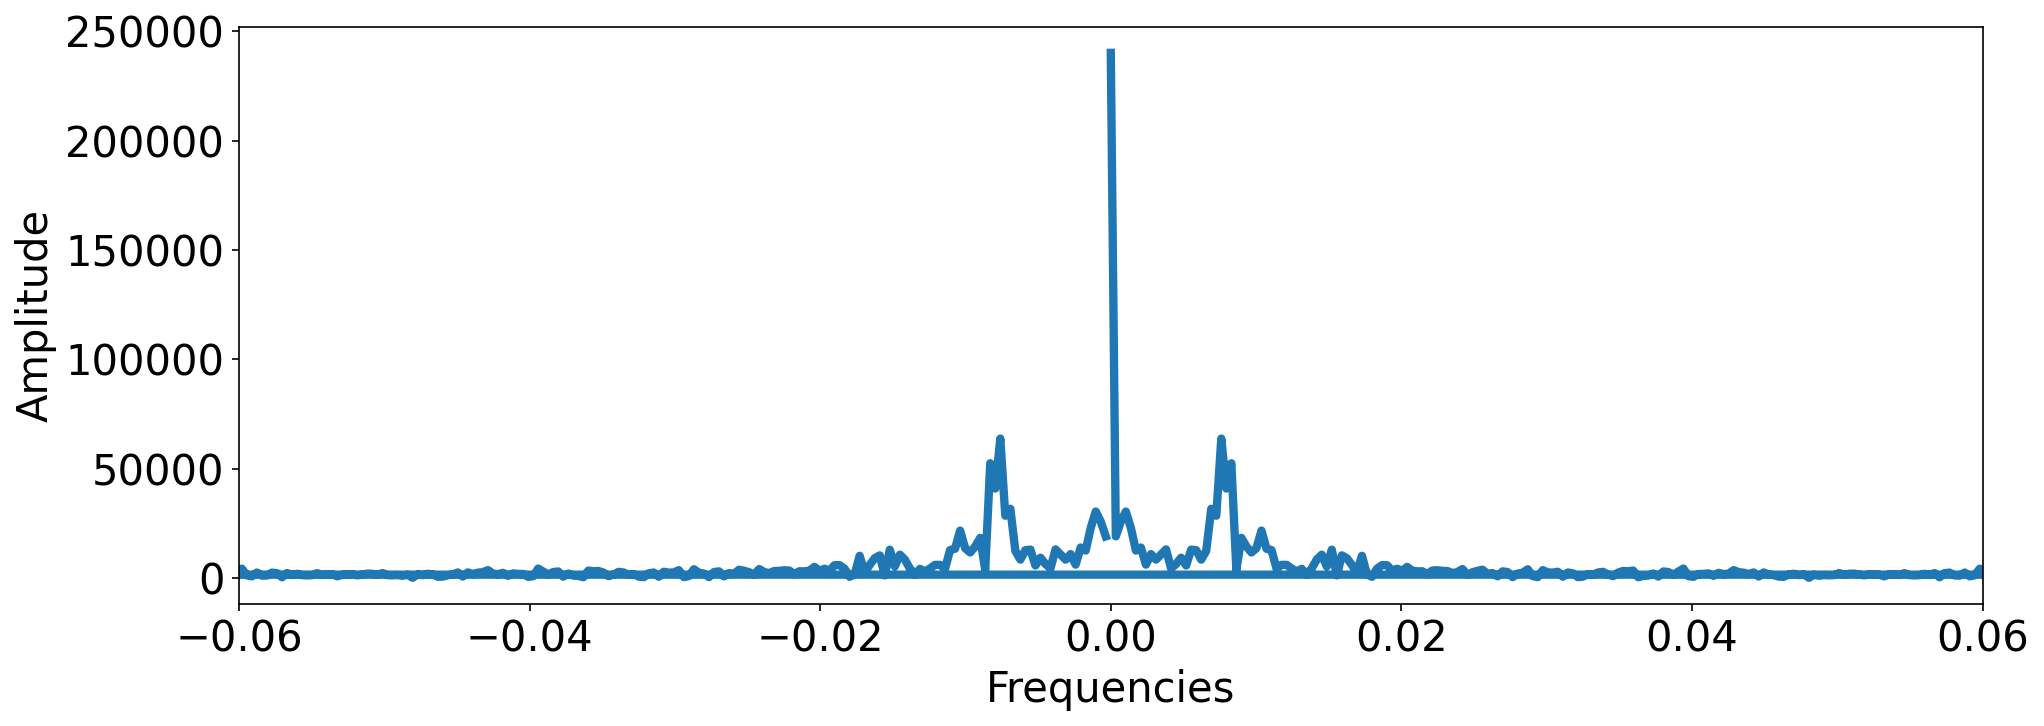

In [5]:
x_width, y_width = 15, 5
plt.figure(figsize=(x_width, y_width), dpi=150)
plt.plot(frequencies, np.abs(fft_result), '-')
plt.xlim(-0.06, 0.06)
plt.xlabel('Frequencies'); plt.ylabel('Amplitude')
plt.show()

In [6]:
# Identify the peak frequency - not needed but interesting to note.
peak_frequency = np.abs(frequencies[np.argmax(fft_result)])

# Zero out frequencies outside a certain range
fft_result_filtered = fft_result.copy()
threshold = 0.1
fft_result_filtered[np.abs(frequencies) > threshold] = 0
print(max(fft_result_filtered))

# Reconstruct the time series
sunspot_data_reconstructed = np.real(np.fft.ifft(fft_result_filtered))
sunspot_train_data['sunspotFFT'] = sunspot_data_reconstructed

## Extrapolating the data for n data points
months = 540 # 24 years ~ 2 cycles

future_points = np.real(np.fft.ifft(np.pad(fft_result_filtered, (0, months))))
future_data_time_index = pd.date_range(start=sunspot_train_data.index[-1] + pd.DateOffset(months=0), periods=months, freq = 'MS')

window_size = 20  # Adjust as needed
smoothed_future_points = np.convolve(future_points, np.ones(window_size)/window_size, mode='valid')

(240211.19999999995-1.0516032489249483e-12j)


C:\Users\levet\AppData\Local\Temp\ipykernel_3032\1551075681.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sunspot_train_data['sunspotFFT'] = sunspot_data_reconstructed


In [7]:
years = 45
months = years*12
print(months)

540


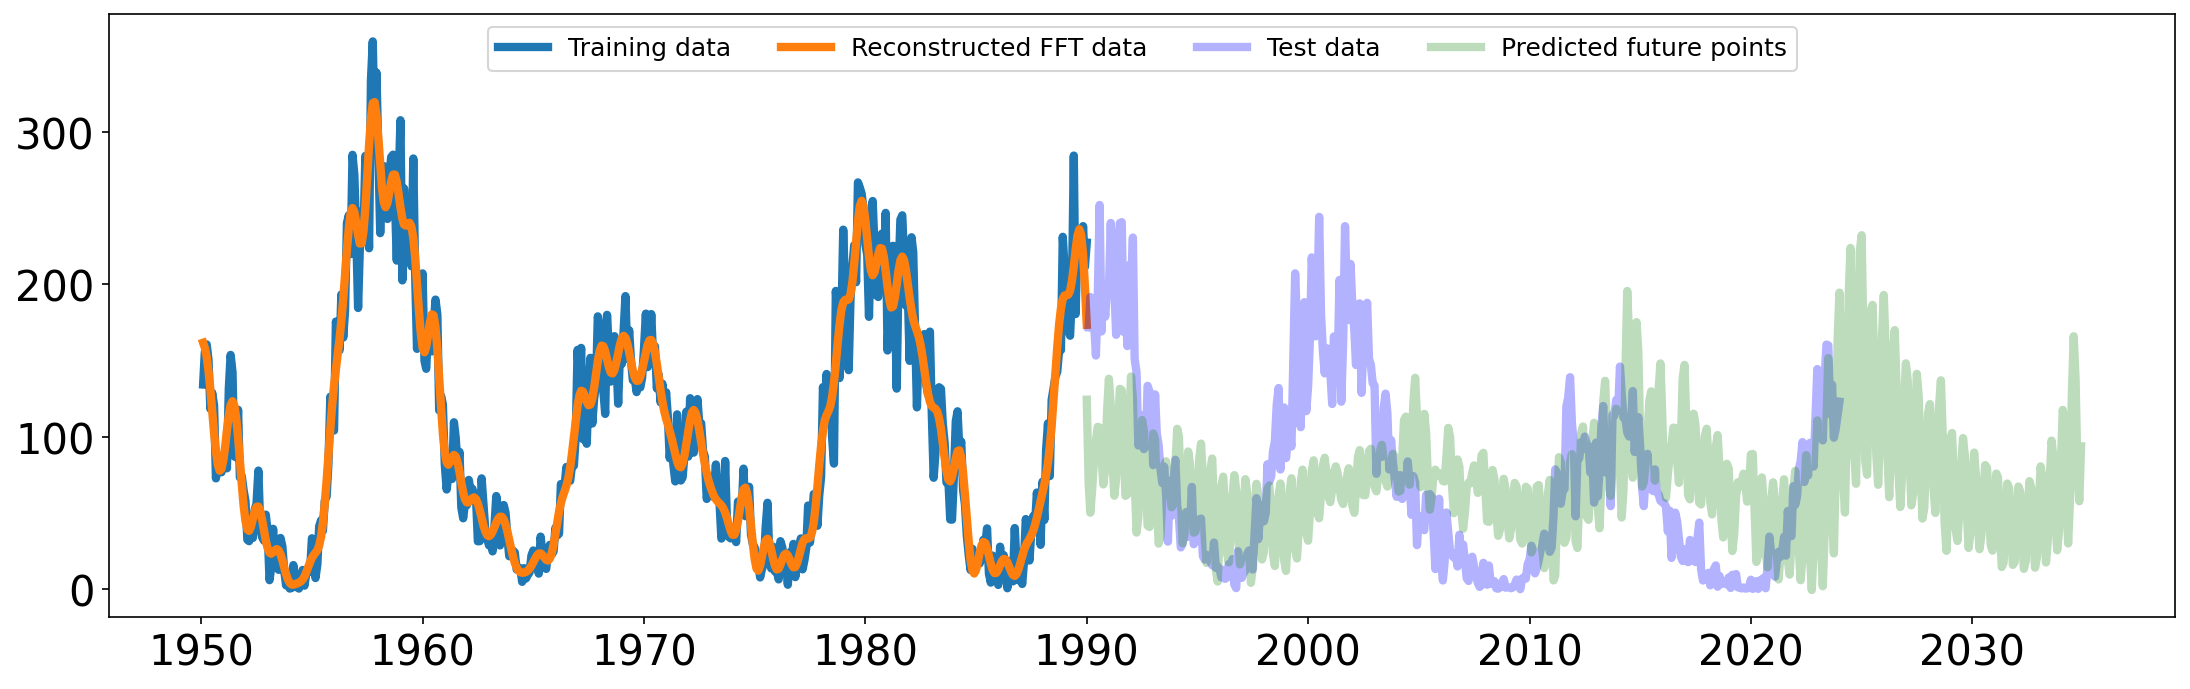

In [8]:
# Plot properties
x_width, y_width = 15, 5

# Create plot
fig, ax = plt.subplots(1, 1, figsize=(x_width, y_width), dpi=150)

date1 = '1950'
cut_off_date = '1990'

ax.plot(sunspot_train_data[(sunspot_train_data.index>date1)]['ssn'], label='Training data')
ax.plot(sunspot_train_data[(sunspot_train_data.index>date1)]['sunspotFFT'], label='Reconstructed FFT data')

ax.plot(dt[(dt.index>cut_off_date)]['ssn'], label='Test data', alpha=0.3, color='blue')

ax.plot(future_data_time_index, future_points[:len(future_data_time_index)], color='forestgreen', label='Predicted future points', alpha=0.3)
# ax.plot(future_data_time_index, smoothed_future_points[:len(future_data_time_index)], color='red', label='Moving average')

ax.legend(loc='upper center', ncol=4, fontsize=12)

plt.tight_layout()
plt.show()

## Applying window functions

In [9]:
# Example with a smoothly tapered window
alpha = 0.1  # Adjust the smoothing factor as needed
windowed_data = sunspot_data * (1 - alpha) + np.hanning(len(sunspot_data)) * alpha


# Compute the Fourier transform of the windowed signal
fft_result = np.fft.fft(windowed_data)
frequencies = np.fft.fftfreq(len(sunspot_data))

fft_result_filtered = fft_result.copy()
threshold = 0.05
fft_result_filtered[np.abs(frequencies) > threshold] = 0
print(max(fft_result_filtered))

# Reconstruct the time series
sunspot_data_reconstructed = np.fft.ifft(fft_result_filtered)

# Visualize the original and windowed signals
fig, ax = plt.subplots(3, 1, figsize=(x_width, y_width), dpi=150)
ax[0].plot(sunspot_data)
ax[0].set_title('Original Signal')

ax[1].plot(windowed_data)
ax[1].set_title('Windowed Signal')

ax[2].plot(sunspot_data_reconstructed)
ax[2].set_title("Applying threshold filter")

plt.tight_layout()
plt.show()

NameError: name 'sunspot_data' is not defined